# Non-linear regression => Newton method

In [1]:
import numpy as np
data = np.array([
0,22.8,
2.3,22.8,
4.9,22.8,
9.1,20.6,
13.7,13.9,
18.3,11.7,
22.9,11.1,
27.2,11.1]).T


In [2]:
z=data[0::2]
T=data[1::2]
z, T

(array([ 0. ,  2.3,  4.9,  9.1, 13.7, 18.3, 22.9, 27.2]),
 array([22.8, 22.8, 22.8, 20.6, 13.9, 11.7, 11.1, 11.1]))

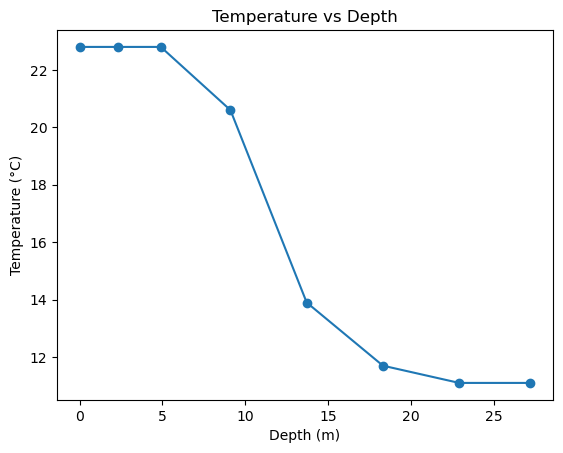

In [3]:
import matplotlib.pyplot as plt
plt.plot(z, T, 'o-')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Temperature vs Depth')
plt.show()

In [4]:
# Nonlinear cubic-like model using tanh envelope with a learnable depth shift.
# T(z) = d + a * tanh(b1*(z - z0) + b2*(z - z0)**2 + b3*(z - z0)**3)
def tanh_cubic_model(z, params):
    d, a, z0, b1, b2, b3 = params
    z_centered = z - z0
    poly = b1 * z_centered + b2 * z_centered**2 + b3 * z_centered**3
    return d + a * np.tanh(poly)


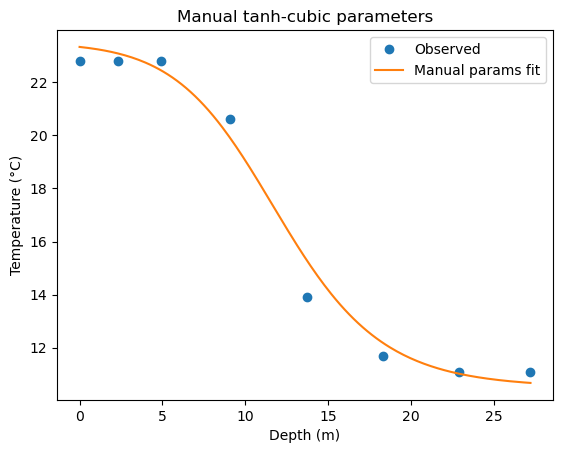

Manual parameters [d, a, b1, b2, b3]: [ 1.7e+01  6.5e+00  1.2e+01 -1.6e-01  1.5e-03 -2.0e-05]


In [5]:
# Manual parameter tweak for tanh-cubic model and plot
manual_params = np.array([
    17.0,    # d: baseline level
    6.5,     # a: amplitude (positive to give warm surface, cool deep)
    12.0,    # z0: center depth
    -0.16,   # b1
    0.0015,  # b2
    -2e-05,  # b3
], dtype=float)

z_plot = np.linspace(z.min(), z.max(), 200)
T_manual = tanh_cubic_model(z_plot, manual_params)

plt.figure()
plt.plot(z, T, 'o', label='Observed')
plt.plot(z_plot, T_manual, '-', label='Manual params fit')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Manual tanh-cubic parameters')
plt.legend()
plt.show()

print('Manual parameters [d, a, b1, b2, b3]:', manual_params)


In [6]:
import numpy as np

def preds_and_jacobian(params, z, T):
    d, a, z0, b1, b2, b3 = params
    zc = z - z0
    poly = b1*zc + b2*zc**2 + b3*zc**3

    t = np.tanh(poly)
    preds = d + a*t
    r = preds - T

    # derivative of tanh: sech^2 = 1 - tanh^2
    sech2 = 1.0 - t**2

    # sensitivities d(pred)/d(param) == d(r)/d(param)
    dr_dd  = np.ones_like(z)
    dr_da  = t
    dr_dz0 = a * sech2 * (-(b1 + 2*b2*zc + 3*b3*zc**2))
    dr_db1 = a * sech2 * zc
    dr_db2 = a * sech2 * zc**2
    dr_db3 = a * sech2 * zc**3

    # Assemble Jacobian J: N x 6
    J = np.column_stack([dr_dd, dr_da, dr_dz0, dr_db1, dr_db2, dr_db3])
    return preds, r, J

def loss_grad(params, z, T):
    preds, r, J = preds_and_jacobian(params, z, T)
    N = z.size
    loss = float(np.mean(r**2))
    grad = (2.0 / N) * (J.T @ r)
    return loss, grad, r, J


In [7]:
def numerical_hessian_of_loss(params, z, T, eps=1e-6):
    """
    Compute Hessian of L(theta) numerically using finite differences on the gradient.
    H_ij ≈ ∂(grad_i)/∂theta_j
    """
    n = params.size
    _, g0, _, _ = loss_grad(params, z, T)
    H = np.zeros((n, n), dtype=float)

    for j in range(n):
        dp = np.zeros(n)
        dp[j] = eps * (1.0 + abs(params[j]))
        _, gj, _, _ = loss_grad(params + dp, z, T)
        H[:, j] = (gj - g0) / dp[j]
    return H

def newton_fit_numeric_hessian(z, T, params, steps=20, damping=1e-6, clip_b=True):
    for step in range(steps):
        loss, grad, r, J = loss_grad(params, z, T)

        H = numerical_hessian_of_loss(params, z, T, eps=1e-6)

        # Damping to ensure invertible / stable
        H_damped = H + damping * np.eye(H.shape[0])

        delta = -np.linalg.solve(H_damped, grad)
        params = params + delta

        if clip_b:
            params[3:] = np.clip(params[3:], -1.0, 1.0)

        if step % 2 == 0:
            print(f"Newton step {step:3d}: loss={loss:.6e}, ||delta||={np.linalg.norm(delta):.3e}, params={params}")

    return params


In [8]:
init_params=manual_params.copy()

In [9]:
def newton_fit(z, T, params, steps=30, damping=1e-1, clip_b=True):
    for step in range(steps):
        loss, grad, r, J = loss_grad(params, z, T)
        N = z.size

        H = numerical_hessian_of_loss(params, z, T) + 1e-6*np.eye(6)
        loss, grad, _, _ = loss_grad(params, z, T)
        delta = -np.linalg.solve(H, grad)
        params += delta
        print('Updated parameters:', params)

        if clip_b:
            params[3:] = np.clip(params[3:], -1.0, 1.0)

        if step % 5 == 0:
            print(f"Newton step {step:3d}: loss={loss:.6e}, ||delta||={np.linalg.norm(delta):.3e}, params={params}")

    return params
final_params = newton_fit(z, T, init_params.copy(), steps=50)
init_params=final_params.copy()

Updated parameters: [ 1.71961023e+01  6.06274157e+00  1.13414164e+01 -2.20160373e-01
  5.38445590e-04  1.81446416e-04]
Newton step   0: loss=4.223022e-01, ||delta||=8.167e-01, params=[ 1.71961023e+01  6.06274157e+00  1.13414164e+01 -2.20160373e-01
  5.38445590e-04  1.81446416e-04]
Updated parameters: [ 1.70268028e+01  6.06862550e+00  1.16248182e+01 -2.60964009e-01
  3.81087821e-04  5.99928274e-04]
Updated parameters: [ 1.70698929e+01  6.03144929e+00  1.16020271e+01 -2.72702796e-01
 -7.07039387e-04  6.52200617e-04]
Updated parameters: [ 1.70895031e+01  6.00600970e+00  1.15920846e+01 -2.75848832e-01
 -1.17455059e-03  6.33754228e-04]
Updated parameters: [ 1.71011781e+01  5.99126342e+00  1.15879977e+01 -2.77087327e-01
 -1.51127178e-03  6.08746351e-04]
Updated parameters: [ 1.71068484e+01  5.98542916e+00  1.15869779e+01 -2.77562594e-01
 -1.72056828e-03  5.93225196e-04]
Newton step   5: loss=1.537936e-02, ||delta||=8.216e-03, params=[ 1.71068484e+01  5.98542916e+00  1.15869779e+01 -2.7756259

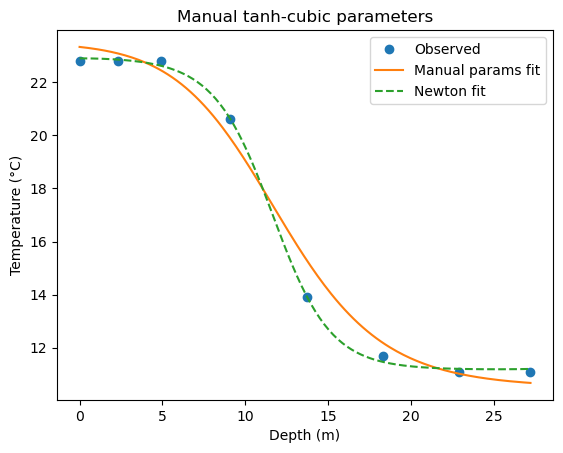

Manual parameters [d, a, b1, b2, b3]: [ 1.7e+01  6.5e+00  1.2e+01 -1.6e-01  1.5e-03 -2.0e-05]


In [10]:
z_plot = np.linspace(z.min(), z.max(), 200)
T_final = tanh_cubic_model(z_plot, final_params)

plt.figure()
plt.plot(z, T, 'o', label='Observed')
plt.plot(z_plot, T_manual, '-', label='Manual params fit')
plt.plot(z_plot, T_final, '--', label='Newton fit')
plt.xlabel('Depth (m)')
plt.ylabel('Temperature (°C)')
plt.title('Manual tanh-cubic parameters')
plt.legend()
plt.show()

print('Manual parameters [d, a, b1, b2, b3]:', manual_params)
